<a href="https://colab.research.google.com/github/toohsk/LoRA-with-Ray-Tuning/blob/main/HF_LoRA_fine_tuning_with_Ray_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U -q datasets transformers[torch] mlflow ray==2.8.0 peft evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

# Setup Ray

In [3]:
from pprint import pprint
import ray

ray.init()

2023-12-18 05:43:46,168	INFO worker.py:1673 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.8.0


In [4]:
pprint(ray.cluster_resources())

{'CPU': 8.0,
 'GPU': 1.0,
 'memory': 32598913844.0,
 'node:172.28.0.12': 1.0,
 'node:__internal_head__': 1.0,
 'object_store_memory': 16299456921.0}


# Create dataset

We are using Yelp review dataset.<br>
Yelp review dataset contains review comment as a text feature and score as a label.

In [5]:
# Download Yelp Reviews dataset from datasets
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
# Show 10-th record.
dataset["train"][10]

{'label': 0,
 'text': "Owning a driving range inside the city limits is like a license to print money.  I don't think I ask much out of a driving range.  Decent mats, clean balls and accessible hours.  Hell you need even less people now with the advent of the machine that doles out the balls.  This place has none of them.  It is april and there are no grass tees yet.  BTW they opened for the season this week although it has been golfing weather for a month.  The mats look like the carpet at my 107 year old aunt Irene's house.  Worn and thread bare.  Let's talk about the hours.  This place is equipped with lights yet they only sell buckets of balls until 730.  It is still light out.  Finally lets you have the pit to hit into.  When I arrived I wasn't sure if this was a driving range or an excavation site for a mastodon or a strip mining operation.  There is no grass on the range. Just mud.  Makes it a good tool to figure out how far you actually are hitting the ball.  Oh, they are cash 

# Prepare tokenizer

In this notebook, we are using BERT model for tokenizer.<br>
This is just a example code so we are only using 3000 instances for training data and 1000 instances for test data for speeding up the training.

Then, we transform the dataset with `ray.data.from_huggingface` function so that we can handle the dataset in Ray.

In [7]:
# Please find the pretrained model which you want to train from models page in hugging face: https://huggingface.co/models?sort=trending
# In this case, we are using BERT base model
pretrained_model = "bert-base-cased"

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model,
)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

dataset = dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/650000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [9]:
# Extract few dataset
seed = 42

small_train_dataset = dataset["train"].shuffle(seed=seed).select(range(1000))
small_eval_dataset = dataset["test"].shuffle(seed=seed).select(range(1000))

In [10]:
small_train_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

In [11]:
small_eval_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

In [12]:
# You can see the processed result with remove following comment out.
# small_eval_dataset[10]

In [13]:
import ray.data

ray_datasets = {
    "train": ray.data.from_huggingface(small_train_dataset),
    "test": ray.data.from_huggingface(small_eval_dataset),
}
ray_datasets

{'train': MaterializedDataset(
    num_blocks=1,
    num_rows=1000,
    schema={
       label: int64,
       text: string,
       input_ids: list<item: int32>,
       token_type_ids: list<item: int8>,
       attention_mask: list<item: int8>
    }
 ),
 'test': MaterializedDataset(
    num_blocks=1,
    num_rows=1000,
    schema={
       label: int64,
       text: string,
       input_ids: list<item: int32>,
       token_type_ids: list<item: int8>,
       attention_mask: list<item: int8>
    }
 )}

# Train LLM with Ray

Now, let's put all above steps and functions into one function.

In [14]:
import torch
import numpy as np
import evaluate

from datasets import load_metric
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import BertForSequenceClassification
from peft import get_peft_model
from peft import LoraConfig, TaskType

import ray.train
from ray.train.huggingface.transformers import prepare_trainer, RayTrainReportCallback

batch_size = 16
train_size = 1000
eval_size = 1000

use_gpu = True    # set this to False to run on CPUs
num_workers = 1  # set this to number of GPUs or CPUs you want to use

# Calculate the maximum steps per epoch based on the number of rows in the training dataset.
# Make sure to scale by the total number of training workers and the per device batch size.
max_steps_per_epoch = train_size // (batch_size * num_workers)


def train_func(config):

    # Datasets
    dataset = load_dataset(config.get("dataset"))
    tokenizer = AutoTokenizer.from_pretrained(config.get("tokenizer_model"))

    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True)

    small_train_dataset = dataset["train"].shuffle(seed=config.get("seed", 42)).select(range(config.get("train_size", 1000))).map(tokenize_function, batched=True)
    small_eval_dataset = dataset["test"].shuffle(seed=config.get("seed", 42)).select(range(config.get("eval_size", 1000))).map(tokenize_function, batched=True)

    # Model
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,                 # What task type are you doing fine-tuning for? For TaskTask, please refer: https://github.com/huggingface/peft/blob/main/src/peft/utils/peft_types.py#L34-L40
        r=config.get("r", 8),                           # the dimension of the low-rank matrices
        lora_alpha=config.get("lora_alpha", 8),         # scaling factor for the weight matrices
        lora_dropout=config.get("lora_dropout", 0.1),  # dropout probability of the LoRA layers
        bias=config.get("bias", "none"),                # Bias type for Lora. Can be 'none', 'all' or 'lora_only'.
    )
    model = AutoModelForSequenceClassification.from_pretrained(
        config.get("pretrained_model"),
        num_labels=5
    )
    # Create a LoRA LLM model with peft
    model = get_peft_model(
        model,
        lora_config
    )

    # Evaluation Metrics
    metric = evaluate.load("accuracy")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    # Hugging Face Trainer
    training_args = TrainingArguments(
        output_dir="test_trainer",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        report_to="none",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=config.get("learning_rate", 2e-5),
        num_train_epochs=config.get("epochs", 2),
        weight_decay=config.get("weight_decay", 0.01),
        max_steps=max_steps_per_epoch * config.get("epochs", 2),
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )

    # Report Metrics and Checkpoints to Ray Train
    callback = ray.train.huggingface.transformers.RayTrainReportCallback()
    trainer.add_callback(callback)

    # Prepare Transformers Trainer
    trainer = ray.train.huggingface.transformers.prepare_trainer(trainer)

    # Start Training
    trainer.train()

In [15]:
from ray.train.torch import TorchTrainer
from ray.train import RunConfig, ScalingConfig, CheckpointConfig


trainer = TorchTrainer(
    train_func,
    scaling_config=ScalingConfig(
        num_workers=1,
        use_gpu=use_gpu,
    ),
    datasets={
        "train": ray_datasets["train"],
        "evaluation": ray_datasets["test"],
    },
)

In [16]:
from ray import tune
from ray.tune.schedulers.async_hyperband import ASHAScheduler

tune_epochs = 5

tuner = tune.Tuner(
    trainer,
    param_space={
        "train_loop_config": {
            # constant params
            "dataset": "yelp_review_full",
            "tokenizer_model": "bert-base-cased",
            "pretrained_model": "bert-base-cased",
            "train_size": train_size,
            "eval_size": eval_size,
            # hyper parameters to search
            "learning_rate": 2e-5,
            "r": tune.grid_search([4, 16,]),
            "lora_alpha": tune.grid_search([4, 16,]),
            "lora_dropout": 1e-2,
            "bias": 'lora_only',
            "epochs": tune_epochs,
        }
    },
    tune_config=tune.TuneConfig(
        metric="eval_loss",
        mode="min",
        num_samples=1,
        scheduler=ASHAScheduler(
            max_t=tune_epochs,
        ),
    ),
    run_config=RunConfig(
        name="tune_transformers",
        checkpoint_config=CheckpointConfig(
            num_to_keep=3,
            checkpoint_score_attribute="eval_loss",
            checkpoint_score_order="min",
        ),
    ),
)

In [17]:
tune_results = tuner.fit()

2023-12-18 05:48:37,015	INFO tune.py:595 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-12-18 05:48:37,024	INFO tensorboardx.py:178 -- pip install "ray[tune]" to see TensorBoard files.
2023-12-18 05:48:37,025	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+----------------------------------------------------------+
| Configuration for experiment     tune_transformers       |
+----------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator   |
| Scheduler                        AsyncHyperBandScheduler |
| Number of trials                 4                       |
+----------------------------------------------------------+

View detailed results here: /root/ray_results/tune_transformers

Trial status: 4 PENDING
Current time: 2023-12-18 05:48:37. Total running time: 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha |
+--------------------------------------------------------------------------------------+
| TorchTrainer_16887_00000   PENDING                        4                        4 |
| TorchTrainer_16887_000

(TrainTrainable pid=3425) 2023-12-18 05:48:42.179346: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(TrainTrainable pid=3425) 2023-12-18 05:48:42.179403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(TrainTrainable pid=3425) 2023-12-18 05:48:42.180677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(TrainTrainable pid=3425) 2023-12-18 05:48:43.203645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial TorchTrainer_16887_00000 started with configuration:
+------------------------------------------------------------+
| Trial TorchTrainer_16887_00000 config                      |
+------------------------------------------------------------+
| train_loop_config/bias                           lora_only |
| train_loop_config/dataset                 yelp_review_full |
| train_loop_config/epochs                                 5 |
| train_loop_config/eval_size                           1000 |
| train_loop_config/learning_rate                      2e-05 |
| train_loop_config/lora_alpha                             4 |
| train_loop_config/lora_dropout                        0.01 |
| train_loop_config/pretrained_model         bert-base-cased |
| train_loop_config/r                                      4 |
| train_loop_config/tokenizer_model          bert-base-cased |
| train_loop_config/train_size                          1000 |
+---------------------------------------------------------

(TorchTrainer pid=3425) Starting distributed worker processes: ['3485 (172.28.0.12)']
(RayTrainWorker pid=3485) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=3485) 2023-12-18 05:48:49.348884: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(RayTrainWorker pid=3485) 2023-12-18 05:48:49.348946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=3485) 2023-12-18 05:48:49.350071: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(SplitCoordinator pid=3533) Auto configuring locality_with_output=['0c00396f252c989ad04dcdf963c9252c4c10f52afa23d47


Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:49:07. Total running time: 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha |
+--------------------------------------------------------------------------------------+
| TorchTrainer_16887_00000   RUNNING                        4                        4 |
| TorchTrainer_16887_00001   PENDING                        4                       16 |
| TorchTrainer_16887_00002   PENDING                       16                        4 |
| TorchTrainer_16887_00003   PENDING                       16                       16 |
+--------------------------------------------------------------------------------------+


(RayTrainWorker pid=3485) [W reducer.cpp:1346] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
  9%|▉         | 28/310 [00:31<05:05,  1.08s/it]


Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:49:37. Total running time: 1min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha |
+--------------------------------------------------------------------------------------+
| TorchTrainer_16887_00000   RUNNING                        4                        4 |
| TorchTrainer_16887_00001   PENDING                        4                       16 |
| TorchTrainer_16887_00002   PENDING                       16                        4 |
| TorchTrainer_16887_00003   PENDING                       16                       16 |
+--------------------------------------------------------------------------------------+


 18%|█▊        | 55/310 [01:01<04:50,  1.14s/it]


Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:50:07. Total running time: 1min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha |
+--------------------------------------------------------------------------------------+
| TorchTrainer_16887_00000   RUNNING                        4                        4 |
| TorchTrainer_16887_00001   PENDING                        4                       16 |
| TorchTrainer_16887_00002   PENDING                       16                        4 |
| TorchTrainer_16887_00003   PENDING                       16                       16 |
+--------------------------------------------------------------------------------------+


 20%|██        | 63/310 [01:10<04:01,  1.02it/s]


(RayTrainWorker pid=3485) {'loss': 1.6581, 'learning_rate': 1.5935483870967744e-05, 'epoch': 1.0}


(RayTrainWorker pid=3485) 
  0%|          | 0/63 [00:00<?, ?it/s]
(RayTrainWorker pid=3485) 
  3%|▎         | 2/63 [00:00<00:17,  3.45it/s]
(RayTrainWorker pid=3485) 
  5%|▍         | 3/63 [00:01<00:23,  2.54it/s]
(RayTrainWorker pid=3485) 
  6%|▋         | 4/63 [00:01<00:27,  2.18it/s]
(RayTrainWorker pid=3485) 
  8%|▊         | 5/63 [00:02<00:28,  2.05it/s]
(RayTrainWorker pid=3485) 
 10%|▉         | 6/63 [00:02<00:29,  1.95it/s]
(RayTrainWorker pid=3485) 
 11%|█         | 7/63 [00:03<00:29,  1.90it/s]
(RayTrainWorker pid=3485) 
 13%|█▎        | 8/63 [00:03<00:29,  1.86it/s]
(RayTrainWorker pid=3485) 
 14%|█▍        | 9/63 [00:04<00:29,  1.84it/s]
(RayTrainWorker pid=3485) 
 16%|█▌        | 10/63 [00:05<00:29,  1.82it/s]
(RayTrainWorker pid=3485) 
 17%|█▋        | 11/63 [00:05<00:28,  1.80it/s]
(RayTrainWorker pid=3485) 
 19%|█▉        | 12/63 [00:06<00:28,  1.80it/s]
(RayTrainWorker pid=3485) 
 21%|██        | 13/63 [00:06<00:27,  1.79it/s]
(RayTrainWorker pid=3485) 
 22%|██▏       

Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:50:37. Total running time: 2min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha |
+--------------------------------------------------------------------------------------+
| TorchTrainer_16887_00000   RUNNING                        4                        4 |
| TorchTrainer_16887_00001   PENDING                        4                       16 |
| TorchTrainer_16887_00002   PENDING                       16                        4 |
| TorchTrainer_16887_00003   PENDING                       16                       16 |
+--------------------------------------------------------------------------------------+


(RayTrainWorker pid=3485) 
 60%|██████    | 38/63 [00:21<00:14,  1.71it/s]
(RayTrainWorker pid=3485) 
 62%|██████▏   | 39/63 [00:21<00:14,  1.71it/s]
(RayTrainWorker pid=3485) 
 63%|██████▎   | 40/63 [00:22<00:13,  1.70it/s]
(RayTrainWorker pid=3485) 
 65%|██████▌   | 41/63 [00:22<00:12,  1.70it/s]
(RayTrainWorker pid=3485) 
 67%|██████▋   | 42/63 [00:23<00:12,  1.70it/s]
(RayTrainWorker pid=3485) 
 68%|██████▊   | 43/63 [00:24<00:11,  1.69it/s]
(RayTrainWorker pid=3485) 
 70%|██████▉   | 44/63 [00:24<00:11,  1.69it/s]
(RayTrainWorker pid=3485) 
 71%|███████▏  | 45/63 [00:25<00:10,  1.69it/s]
(RayTrainWorker pid=3485) 
 73%|███████▎  | 46/63 [00:25<00:10,  1.68it/s]
(RayTrainWorker pid=3485) 
 75%|███████▍  | 47/63 [00:26<00:09,  1.68it/s]
(RayTrainWorker pid=3485) 
 76%|███████▌  | 48/63 [00:27<00:08,  1.68it/s]
(RayTrainWorker pid=3485) 
 78%|███████▊  | 49/63 [00:27<00:08,  1.68it/s]
(RayTrainWorker pid=3485) 
 79%|███████▉  | 50/63 [00:28<00:07,  1.68it/s]
(RayTrainWorker pid=3485)

(RayTrainWorker pid=3485) {'eval_loss': 1.6143484115600586, 'eval_accuracy': 0.213, 'eval_runtime': 36.3405, 'eval_samples_per_second': 27.518, 'eval_steps_per_second': 1.734, 'epoch': 1.0}


 24%|██▍       | 75/310 [02:01<05:34,  1.42s/it]


Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:51:07. Total running time: 2min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.6143484115600586 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTraine

 32%|███▏      | 100/310 [02:30<04:09,  1.19s/it]


Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:51:37. Total running time: 3min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.6143484115600586 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer

 41%|████      | 126/310 [03:01<03:06,  1.02s/it]


(RayTrainWorker pid=3485) {'loss': 1.6157, 'learning_rate': 1.1870967741935484e-05, 'epoch': 2.0}
Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:52:07. Total running time: 3min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.6143484115600586 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+-----------------------------------------------------------------------------

(RayTrainWorker pid=3485) 
  0%|          | 0/63 [00:00<?, ?it/s]
(RayTrainWorker pid=3485) 
  3%|▎         | 2/63 [00:00<00:18,  3.34it/s]
(RayTrainWorker pid=3485) 
  5%|▍         | 3/63 [00:01<00:24,  2.40it/s]
(RayTrainWorker pid=3485) 
  6%|▋         | 4/63 [00:01<00:28,  2.08it/s]
(RayTrainWorker pid=3485) 
  8%|▊         | 5/63 [00:02<00:30,  1.93it/s]
(RayTrainWorker pid=3485) 
 10%|▉         | 6/63 [00:02<00:30,  1.86it/s]
(RayTrainWorker pid=3485) 
 11%|█         | 7/63 [00:03<00:31,  1.80it/s]
(RayTrainWorker pid=3485) 
 13%|█▎        | 8/63 [00:04<00:30,  1.77it/s]
(RayTrainWorker pid=3485) 
 14%|█▍        | 9/63 [00:04<00:30,  1.74it/s]
(RayTrainWorker pid=3485) 
 16%|█▌        | 10/63 [00:05<00:30,  1.73it/s]
(RayTrainWorker pid=3485) 
 17%|█▋        | 11/63 [00:05<00:30,  1.73it/s]
(RayTrainWorker pid=3485) 
 19%|█▉        | 12/63 [00:06<00:29,  1.71it/s]
(RayTrainWorker pid=3485) 
 21%|██        | 13/63 [00:07<00:29,  1.72it/s]
(RayTrainWorker pid=3485) 
 22%|██▏       

Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:52:37. Total running time: 4min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.6143484115600586 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer

(RayTrainWorker pid=3485) 
 84%|████████▍ | 53/63 [00:30<00:05,  1.72it/s]
(RayTrainWorker pid=3485) 
 86%|████████▌ | 54/63 [00:31<00:05,  1.72it/s]
(RayTrainWorker pid=3485) 
 87%|████████▋ | 55/63 [00:31<00:04,  1.72it/s]
(RayTrainWorker pid=3485) 
 89%|████████▉ | 56/63 [00:32<00:04,  1.72it/s]
(RayTrainWorker pid=3485) 
 90%|█████████ | 57/63 [00:32<00:03,  1.72it/s]
(RayTrainWorker pid=3485) 
 92%|█████████▏| 58/63 [00:33<00:02,  1.72it/s]
(RayTrainWorker pid=3485) 
 94%|█████████▎| 59/63 [00:33<00:02,  1.72it/s]
(RayTrainWorker pid=3485) 
 95%|█████████▌| 60/63 [00:34<00:01,  1.72it/s]
(RayTrainWorker pid=3485) 
 97%|█████████▋| 61/63 [00:35<00:01,  1.72it/s]
(RayTrainWorker pid=3485) 
 98%|█████████▊| 62/63 [00:35<00:00,  1.72it/s]
(RayTrainWorker pid=3485) 
                                                 
100%|██████████| 63/63 [00:35<00:00,  2.05it/s]
                                               
(RayTrainWorker pid=3485) Checkpoint successfully created at: Checkpoint(file

(RayTrainWorker pid=3485) {'eval_loss': 1.5986112356185913, 'eval_accuracy': 0.222, 'eval_runtime': 36.5386, 'eval_samples_per_second': 27.368, 'eval_steps_per_second': 1.724, 'epoch': 2.0}


 47%|████▋     | 146/310 [04:01<03:17,  1.20s/it]


Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:53:07. Total running time: 4min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5986112356185913 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTraine

 55%|█████▌    | 171/310 [04:31<02:46,  1.20s/it]


Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:53:37. Total running time: 5min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5986112356185913 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer

 61%|██████    | 189/310 [04:52<02:02,  1.02s/it]


(RayTrainWorker pid=3485) {'loss': 1.6068, 'learning_rate': 7.806451612903227e-06, 'epoch': 3.0}


(RayTrainWorker pid=3485) 
  0%|          | 0/63 [00:00<?, ?it/s]
(RayTrainWorker pid=3485) 
  3%|▎         | 2/63 [00:00<00:18,  3.38it/s]
(RayTrainWorker pid=3485) 
  5%|▍         | 3/63 [00:01<00:24,  2.41it/s]
(RayTrainWorker pid=3485) 
  6%|▋         | 4/63 [00:01<00:28,  2.09it/s]
(RayTrainWorker pid=3485) 
  8%|▊         | 5/63 [00:02<00:29,  1.93it/s]
(RayTrainWorker pid=3485) 
 10%|▉         | 6/63 [00:02<00:30,  1.86it/s]
(RayTrainWorker pid=3485) 
 11%|█         | 7/63 [00:03<00:30,  1.81it/s]
(RayTrainWorker pid=3485) 
 13%|█▎        | 8/63 [00:04<00:30,  1.78it/s]
(RayTrainWorker pid=3485) 
 14%|█▍        | 9/63 [00:04<00:30,  1.76it/s]
(RayTrainWorker pid=3485) 
 16%|█▌        | 10/63 [00:05<00:30,  1.75it/s]
(RayTrainWorker pid=3485) 
 17%|█▋        | 11/63 [00:05<00:30,  1.73it/s]
(RayTrainWorker pid=3485) 
 19%|█▉        | 12/63 [00:06<00:29,  1.72it/s]
(RayTrainWorker pid=3485) 
 21%|██        | 13/63 [00:07<00:29,  1.72it/s]
(RayTrainWorker pid=3485) 
 22%|██▏       

Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:54:07. Total running time: 5min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5986112356185913 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTraine

(RayTrainWorker pid=3485) 
 25%|██▌       | 16/63 [00:08<00:27,  1.72it/s]
(RayTrainWorker pid=3485) 
 27%|██▋       | 17/63 [00:09<00:26,  1.72it/s]
(RayTrainWorker pid=3485) 
 29%|██▊       | 18/63 [00:09<00:26,  1.72it/s]
(RayTrainWorker pid=3485) 
 30%|███       | 19/63 [00:10<00:25,  1.71it/s]
(RayTrainWorker pid=3485) 
 32%|███▏      | 20/63 [00:11<00:25,  1.71it/s]
(RayTrainWorker pid=3485) 
 33%|███▎      | 21/63 [00:11<00:24,  1.71it/s]
(RayTrainWorker pid=3485) 
 35%|███▍      | 22/63 [00:12<00:23,  1.71it/s]
(RayTrainWorker pid=3485) 
 37%|███▋      | 23/63 [00:12<00:23,  1.71it/s]
(RayTrainWorker pid=3485) 
 38%|███▊      | 24/63 [00:13<00:22,  1.71it/s]
(RayTrainWorker pid=3485) 
 40%|███▉      | 25/63 [00:14<00:22,  1.72it/s]
(RayTrainWorker pid=3485) 
 41%|████▏     | 26/63 [00:14<00:21,  1.72it/s]
(RayTrainWorker pid=3485) 
 43%|████▎     | 27/63 [00:15<00:20,  1.72it/s]
(RayTrainWorker pid=3485) 
 44%|████▍     | 28/63 [00:15<00:20,  1.71it/s]
(RayTrainWorker pid=3485)

(RayTrainWorker pid=3485) {'eval_loss': 1.593562126159668, 'eval_accuracy': 0.238, 'eval_runtime': 36.4669, 'eval_samples_per_second': 27.422, 'eval_steps_per_second': 1.728, 'epoch': 3.0}


 62%|██████▏   | 191/310 [05:31<17:24,  8.77s/it]


Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:54:37. Total running time: 6min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.593562126159668 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_

 70%|██████▉   | 216/310 [06:01<01:52,  1.19s/it]


Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:55:07. Total running time: 6min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.593562126159668 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer

 78%|███████▊  | 241/310 [06:31<01:22,  1.19s/it]


Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:55:37. Total running time: 7min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.593562126159668 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_

 81%|████████▏ | 252/310 [06:43<00:58,  1.01s/it]


(RayTrainWorker pid=3485) {'loss': 1.6084, 'learning_rate': 3.741935483870968e-06, 'epoch': 4.0}


(RayTrainWorker pid=3485) 
  0%|          | 0/63 [00:00<?, ?it/s]
(RayTrainWorker pid=3485) 
  3%|▎         | 2/63 [00:00<00:17,  3.41it/s]
(RayTrainWorker pid=3485) 
  5%|▍         | 3/63 [00:01<00:24,  2.44it/s]
(RayTrainWorker pid=3485) 
  6%|▋         | 4/63 [00:01<00:28,  2.11it/s]
(RayTrainWorker pid=3485) 
  8%|▊         | 5/63 [00:02<00:29,  1.95it/s]
(RayTrainWorker pid=3485) 
 10%|▉         | 6/63 [00:02<00:30,  1.88it/s]
(RayTrainWorker pid=3485) 
 11%|█         | 7/63 [00:03<00:30,  1.82it/s]
(RayTrainWorker pid=3485) 
 13%|█▎        | 8/63 [00:04<00:30,  1.79it/s]
(RayTrainWorker pid=3485) 
 14%|█▍        | 9/63 [00:04<00:30,  1.77it/s]
(RayTrainWorker pid=3485) 
 16%|█▌        | 10/63 [00:05<00:30,  1.75it/s]
(RayTrainWorker pid=3485) 
 17%|█▋        | 11/63 [00:05<00:29,  1.74it/s]
(RayTrainWorker pid=3485) 
 19%|█▉        | 12/63 [00:06<00:29,  1.73it/s]
(RayTrainWorker pid=3485) 
 21%|██        | 13/63 [00:06<00:28,  1.73it/s]
(RayTrainWorker pid=3485) 
 22%|██▏       

Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:56:07. Total running time: 7min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.593562126159668 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer

(RayTrainWorker pid=3485) 
 51%|█████     | 32/63 [00:17<00:17,  1.73it/s]
(RayTrainWorker pid=3485) 
 52%|█████▏    | 33/63 [00:18<00:17,  1.72it/s]
(RayTrainWorker pid=3485) 
 54%|█████▍    | 34/63 [00:19<00:16,  1.72it/s]
(RayTrainWorker pid=3485) 
 56%|█████▌    | 35/63 [00:19<00:16,  1.72it/s]
(RayTrainWorker pid=3485) 
 57%|█████▋    | 36/63 [00:20<00:15,  1.72it/s]
(RayTrainWorker pid=3485) 
 59%|█████▊    | 37/63 [00:20<00:15,  1.72it/s]
(RayTrainWorker pid=3485) 
 60%|██████    | 38/63 [00:21<00:14,  1.72it/s]
(RayTrainWorker pid=3485) 
 62%|██████▏   | 39/63 [00:22<00:13,  1.73it/s]
(RayTrainWorker pid=3485) 
 63%|██████▎   | 40/63 [00:22<00:13,  1.73it/s]
(RayTrainWorker pid=3485) 
 65%|██████▌   | 41/63 [00:23<00:12,  1.73it/s]
(RayTrainWorker pid=3485) 
 67%|██████▋   | 42/63 [00:23<00:12,  1.73it/s]
(RayTrainWorker pid=3485) 
 68%|██████▊   | 43/63 [00:24<00:11,  1.72it/s]
(RayTrainWorker pid=3485) 
 70%|██████▉   | 44/63 [00:24<00:11,  1.72it/s]
(RayTrainWorker pid=3485)

(RayTrainWorker pid=3485) {'eval_loss': 1.592344045639038, 'eval_accuracy': 0.239, 'eval_runtime': 36.2358, 'eval_samples_per_second': 27.597, 'eval_steps_per_second': 1.739, 'epoch': 4.0}


 85%|████████▍ | 262/310 [07:31<01:17,  1.62s/it]


Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:56:37. Total running time: 8min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.592344045639038 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_

 93%|█████████▎| 287/310 [08:01<00:27,  1.20s/it]


Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:57:07. Total running time: 8min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.592344045639038 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer

100%|██████████| 310/310 [08:29<00:00,  1.20s/it]


(RayTrainWorker pid=3485) {'loss': 1.6128, 'learning_rate': 0.0, 'epoch': 4.92}


(RayTrainWorker pid=3485) 
  0%|          | 0/63 [00:00<?, ?it/s]
(RayTrainWorker pid=3485) 
  3%|▎         | 2/63 [00:00<00:17,  3.45it/s]
(RayTrainWorker pid=3485) 
  5%|▍         | 3/63 [00:01<00:24,  2.42it/s]
(RayTrainWorker pid=3485) 
  6%|▋         | 4/63 [00:01<00:28,  2.10it/s]


Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:57:37. Total running time: 9min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.592344045639038 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_

(RayTrainWorker pid=3485) 
  8%|▊         | 5/63 [00:02<00:29,  1.94it/s]
(RayTrainWorker pid=3485) 
 10%|▉         | 6/63 [00:02<00:30,  1.86it/s]
(RayTrainWorker pid=3485) 
 11%|█         | 7/63 [00:03<00:30,  1.82it/s]
(RayTrainWorker pid=3485) 
 13%|█▎        | 8/63 [00:04<00:30,  1.78it/s]
(RayTrainWorker pid=3485) 
 14%|█▍        | 9/63 [00:04<00:30,  1.76it/s]
(RayTrainWorker pid=3485) 
 16%|█▌        | 10/63 [00:05<00:30,  1.74it/s]
(RayTrainWorker pid=3485) 
 17%|█▋        | 11/63 [00:05<00:29,  1.74it/s]
(RayTrainWorker pid=3485) 
 19%|█▉        | 12/63 [00:06<00:29,  1.72it/s]
(RayTrainWorker pid=3485) 
 21%|██        | 13/63 [00:07<00:29,  1.72it/s]
(RayTrainWorker pid=3485) 
 22%|██▏       | 14/63 [00:07<00:28,  1.72it/s]
(RayTrainWorker pid=3485) 
 24%|██▍       | 15/63 [00:08<00:27,  1.72it/s]
(RayTrainWorker pid=3485) 
 25%|██▌       | 16/63 [00:08<00:27,  1.72it/s]
(RayTrainWorker pid=3485) 
 27%|██▋       | 17/63 [00:09<00:26,  1.71it/s]
(RayTrainWorker pid=3485) 
 29

Trial status: 1 RUNNING | 3 PENDING
Current time: 2023-12-18 05:58:07. Total running time: 9min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.592344045639038 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer

(RayTrainWorker pid=3485) 
 90%|█████████ | 57/63 [00:32<00:03,  1.73it/s]
(RayTrainWorker pid=3485) 
 92%|█████████▏| 58/63 [00:33<00:02,  1.73it/s]
(RayTrainWorker pid=3485) 
 94%|█████████▎| 59/63 [00:33<00:02,  1.73it/s]
(RayTrainWorker pid=3485) 
 95%|█████████▌| 60/63 [00:34<00:01,  1.73it/s]
(RayTrainWorker pid=3485) 
 97%|█████████▋| 61/63 [00:34<00:01,  1.73it/s]
(RayTrainWorker pid=3485) 
 98%|█████████▊| 62/63 [00:35<00:00,  1.73it/s]



Trial TorchTrainer_16887_00000 completed after 5 iterations at 2023-12-18 05:58:11. Total running time: 9min 34s
+-------------------------------------------------------------+
| Trial TorchTrainer_16887_00000 result                       |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000004 |
| time_this_iter_s                                   105.7477 |
| time_total_s                                       566.8939 |
| training_iteration                                        5 |
| epoch                                                  4.92 |
| eval_accuracy                                         0.244 |
| eval_loss                                           1.59221 |
| eval_runtime                                        36.3678 |
| eval_samples_per_second                              27.497 |
| eval_steps_per_second                                 1.732 |
| learning_rate                                       

(RayTrainWorker pid=3485) 
                                                 
100%|██████████| 63/63 [00:35<00:00,  2.05it/s]
                                               Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/tune_transformers/TorchTrainer_16887_00000_0_lora_alpha=4,r=4_2023-12-18_05-48-37/checkpoint_000004)
100%|██████████| 310/310 [09:05<00:00,  1.76s/it]
(TrainTrainable pid=5908) 2023-12-18 05:58:17.107687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(TrainTrainable pid=5908) 2023-12-18 05:58:17.107729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(TrainTrainable pid=5908) 2023-12-18 05:58:17.109076: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:151


Trial TorchTrainer_16887_00001 started with configuration:
+------------------------------------------------------------+
| Trial TorchTrainer_16887_00001 config                      |
+------------------------------------------------------------+
| train_loop_config/bias                           lora_only |
| train_loop_config/dataset                 yelp_review_full |
| train_loop_config/epochs                                 5 |
| train_loop_config/eval_size                           1000 |
| train_loop_config/learning_rate                      2e-05 |
| train_loop_config/lora_alpha                            16 |
| train_loop_config/lora_dropout                        0.01 |
| train_loop_config/pretrained_model         bert-base-cased |
| train_loop_config/r                                      4 |
| train_loop_config/tokenizer_model          bert-base-cased |
| train_loop_config/train_size                          1000 |
+---------------------------------------------------------

(TorchTrainer pid=5908) Starting distributed worker processes: ['5964 (172.28.0.12)']
(RayTrainWorker pid=5964) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=5964) 2023-12-18 05:58:24.091411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(RayTrainWorker pid=5964) 2023-12-18 05:58:24.091455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=5964) 2023-12-18 05:58:24.092641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(SplitCoordinator pid=6008) Auto configuring locality_with_output=['0c00396f252c989ad04dcdf963c9252c4c10f52afa23d47


Trial status: 1 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-12-18 05:58:37. Total running time: 10min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------

  9%|▉         | 28/310 [00:33<05:46,  1.23s/it]


Trial status: 1 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-12-18 05:59:07. Total running time: 10min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------

 17%|█▋        | 53/310 [01:04<05:06,  1.19s/it]


Trial status: 1 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-12-18 05:59:37. Total running time: 11min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------

 20%|██        | 62/310 [01:15<04:53,  1.18s/it]


(RayTrainWorker pid=5964) {'loss': 1.6356, 'learning_rate': 1.5935483870967744e-05, 'epoch': 1.0}


 20%|██        | 63/310 [01:15<04:07,  1.00s/it]
(RayTrainWorker pid=5964) 
  0%|          | 0/63 [00:00<?, ?it/s]
(RayTrainWorker pid=5964) 
  3%|▎         | 2/63 [00:00<00:17,  3.42it/s]
(RayTrainWorker pid=5964) 
  5%|▍         | 3/63 [00:01<00:24,  2.48it/s]
(RayTrainWorker pid=5964) 
  6%|▋         | 4/63 [00:01<00:27,  2.14it/s]
(RayTrainWorker pid=5964) 
  8%|▊         | 5/63 [00:02<00:29,  2.00it/s]
(RayTrainWorker pid=5964) 
 10%|▉         | 6/63 [00:02<00:29,  1.91it/s]
(RayTrainWorker pid=5964) 
 11%|█         | 7/63 [00:03<00:30,  1.86it/s]
(RayTrainWorker pid=5964) 
 13%|█▎        | 8/63 [00:03<00:29,  1.83it/s]
(RayTrainWorker pid=5964) 
 14%|█▍        | 9/63 [00:04<00:29,  1.81it/s]
(RayTrainWorker pid=5964) 
 16%|█▌        | 10/63 [00:05<00:29,  1.80it/s]
(RayTrainWorker pid=5964) 
 17%|█▋        | 11/63 [00:05<00:29,  1.78it/s]
(RayTrainWorker pid=5964) 
 19%|█▉        | 12/63 [00:06<00:28,  1.77it/s]
(RayTrainWorker pid=5964) 
 21%|██        | 13/63 [00:06<00:28,  1.7

Trial status: 1 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-12-18 06:00:08. Total running time: 11min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=5964) 
 54%|█████▍    | 34/63 [00:18<00:16,  1.74it/s]
(RayTrainWorker pid=5964) 
 56%|█████▌    | 35/63 [00:19<00:16,  1.74it/s]
(RayTrainWorker pid=5964) 
 57%|█████▋    | 36/63 [00:19<00:15,  1.74it/s]
(RayTrainWorker pid=5964) 
 59%|█████▊    | 37/63 [00:20<00:14,  1.74it/s]
(RayTrainWorker pid=5964) 
 60%|██████    | 38/63 [00:21<00:14,  1.74it/s]
(RayTrainWorker pid=5964) 
 62%|██████▏   | 39/63 [00:21<00:13,  1.74it/s]
(RayTrainWorker pid=5964) 
 63%|██████▎   | 40/63 [00:22<00:13,  1.74it/s]
(RayTrainWorker pid=5964) 
 65%|██████▌   | 41/63 [00:22<00:12,  1.74it/s]
(RayTrainWorker pid=5964) 
 67%|██████▋   | 42/63 [00:23<00:12,  1.74it/s]
(RayTrainWorker pid=5964) 
 68%|██████▊   | 43/63 [00:24<00:11,  1.74it/s]
(RayTrainWorker pid=5964) 
 70%|██████▉   | 44/63 [00:24<00:10,  1.73it/s]
(RayTrainWorker pid=5964) 
 71%|███████▏  | 45/63 [00:25<00:10,  1.74it/s]
(RayTrainWorker pid=5964) 
 73%|███████▎  | 46/63 [00:25<00:09,  1.73it/s]
(RayTrainWorker pid=5964)

(RayTrainWorker pid=5964) {'eval_loss': 1.6126188039779663, 'eval_accuracy': 0.221, 'eval_runtime': 35.9152, 'eval_samples_per_second': 27.843, 'eval_steps_per_second': 1.754, 'epoch': 1.0}


 24%|██▎       | 73/310 [02:03<06:27,  1.63s/it]


Trial status: 1 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-12-18 06:00:38. Total running time: 12min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------

 32%|███▏      | 99/310 [02:34<04:12,  1.20s/it]


Trial status: 1 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-12-18 06:01:08. Total running time: 12min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------

 40%|████      | 124/310 [03:04<03:41,  1.19s/it]


Trial status: 1 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-12-18 06:01:38. Total running time: 13min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------

 40%|████      | 125/310 [03:05<03:40,  1.19s/it]


(RayTrainWorker pid=5964) {'loss': 1.62, 'learning_rate': 1.1870967741935484e-05, 'epoch': 2.0}


 41%|████      | 126/310 [03:06<03:05,  1.01s/it]
(RayTrainWorker pid=5964) 
  0%|          | 0/63 [00:00<?, ?it/s]
(RayTrainWorker pid=5964) 
  3%|▎         | 2/63 [00:00<00:17,  3.41it/s]
(RayTrainWorker pid=5964) 
  5%|▍         | 3/63 [00:01<00:24,  2.44it/s]
(RayTrainWorker pid=5964) 
  6%|▋         | 4/63 [00:01<00:27,  2.11it/s]
(RayTrainWorker pid=5964) 
  8%|▊         | 5/63 [00:02<00:29,  1.95it/s]
(RayTrainWorker pid=5964) 
 10%|▉         | 6/63 [00:02<00:30,  1.88it/s]
(RayTrainWorker pid=5964) 
 11%|█         | 7/63 [00:03<00:30,  1.82it/s]
(RayTrainWorker pid=5964) 
 13%|█▎        | 8/63 [00:04<00:30,  1.80it/s]
(RayTrainWorker pid=5964) 
 14%|█▍        | 9/63 [00:04<00:30,  1.77it/s]
(RayTrainWorker pid=5964) 
 16%|█▌        | 10/63 [00:05<00:30,  1.76it/s]
(RayTrainWorker pid=5964) 
 17%|█▋        | 11/63 [00:05<00:29,  1.75it/s]
(RayTrainWorker pid=5964) 
 19%|█▉        | 12/63 [00:06<00:29,  1.74it/s]
(RayTrainWorker pid=5964) 
 21%|██        | 13/63 [00:06<00:28,  1.

Trial status: 1 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-12-18 06:02:08. Total running time: 13min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=5964) 
 79%|███████▉  | 50/63 [00:28<00:07,  1.73it/s]
(RayTrainWorker pid=5964) 
 81%|████████  | 51/63 [00:28<00:06,  1.73it/s]
(RayTrainWorker pid=5964) 
 83%|████████▎ | 52/63 [00:29<00:06,  1.73it/s]
(RayTrainWorker pid=5964) 
 84%|████████▍ | 53/63 [00:30<00:05,  1.73it/s]
(RayTrainWorker pid=5964) 
 86%|████████▌ | 54/63 [00:30<00:05,  1.73it/s]
(RayTrainWorker pid=5964) 
 87%|████████▋ | 55/63 [00:31<00:04,  1.73it/s]
(RayTrainWorker pid=5964) 
 89%|████████▉ | 56/63 [00:31<00:04,  1.73it/s]
(RayTrainWorker pid=5964) 
 90%|█████████ | 57/63 [00:32<00:03,  1.73it/s]
(RayTrainWorker pid=5964) 
 92%|█████████▏| 58/63 [00:32<00:02,  1.73it/s]
(RayTrainWorker pid=5964) 
 94%|█████████▎| 59/63 [00:33<00:02,  1.73it/s]
(RayTrainWorker pid=5964) 
 95%|█████████▌| 60/63 [00:34<00:01,  1.73it/s]
(RayTrainWorker pid=5964) 
 97%|█████████▋| 61/63 [00:34<00:01,  1.73it/s]
(RayTrainWorker pid=5964) 
 98%|█████████▊| 62/63 [00:35<00:00,  1.74it/s]
(RayTrainWorker pid=5964)

(RayTrainWorker pid=5964) {'eval_loss': 1.610829472541809, 'eval_accuracy': 0.198, 'eval_runtime': 36.1589, 'eval_samples_per_second': 27.656, 'eval_steps_per_second': 1.742, 'epoch': 2.0}


 46%|████▋     | 144/310 [04:04<03:22,  1.22s/it]


Trial status: 1 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-12-18 06:02:38. Total running time: 14min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------

 55%|█████▍    | 169/310 [04:34<02:49,  1.20s/it]


Trial status: 1 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-12-18 06:03:08. Total running time: 14min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------

 61%|██████    | 188/310 [04:56<02:25,  1.19s/it]


(RayTrainWorker pid=5964) {'loss': 1.6211, 'learning_rate': 7.806451612903227e-06, 'epoch': 3.0}


 61%|██████    | 189/310 [04:57<02:02,  1.01s/it]
(RayTrainWorker pid=5964) 
  0%|          | 0/63 [00:00<?, ?it/s]
(RayTrainWorker pid=5964) 
  3%|▎         | 2/63 [00:00<00:18,  3.39it/s]
(RayTrainWorker pid=5964) 
  5%|▍         | 3/63 [00:01<00:24,  2.44it/s]
(RayTrainWorker pid=5964) 
  6%|▋         | 4/63 [00:01<00:28,  2.11it/s]
(RayTrainWorker pid=5964) 
  8%|▊         | 5/63 [00:02<00:29,  1.95it/s]
(RayTrainWorker pid=5964) 
 10%|▉         | 6/63 [00:02<00:30,  1.88it/s]
(RayTrainWorker pid=5964) 
 11%|█         | 7/63 [00:03<00:30,  1.81it/s]
(RayTrainWorker pid=5964) 
 13%|█▎        | 8/63 [00:04<00:30,  1.79it/s]
(RayTrainWorker pid=5964) 
 14%|█▍        | 9/63 [00:04<00:30,  1.77it/s]
(RayTrainWorker pid=5964) 
 16%|█▌        | 10/63 [00:05<00:30,  1.75it/s]
(RayTrainWorker pid=5964) 
 17%|█▋        | 11/63 [00:05<00:29,  1.74it/s]
(RayTrainWorker pid=5964) 
 19%|█▉        | 12/63 [00:06<00:29,  1.73it/s]
(RayTrainWorker pid=5964) 
 21%|██        | 13/63 [00:06<00:28,  1.

Trial status: 1 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-12-18 06:03:38. Total running time: 15min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=5964) 
 22%|██▏       | 14/63 [00:07<00:28,  1.72it/s]
(RayTrainWorker pid=5964) 
 24%|██▍       | 15/63 [00:08<00:27,  1.72it/s]
(RayTrainWorker pid=5964) 
 25%|██▌       | 16/63 [00:08<00:27,  1.72it/s]
(RayTrainWorker pid=5964) 
 27%|██▋       | 17/63 [00:09<00:26,  1.72it/s]
(RayTrainWorker pid=5964) 
 29%|██▊       | 18/63 [00:09<00:26,  1.72it/s]
(RayTrainWorker pid=5964) 
 30%|███       | 19/63 [00:10<00:25,  1.72it/s]
(RayTrainWorker pid=5964) 
 32%|███▏      | 20/63 [00:11<00:24,  1.72it/s]
(RayTrainWorker pid=5964) 
 33%|███▎      | 21/63 [00:11<00:24,  1.72it/s]
(RayTrainWorker pid=5964) 
 35%|███▍      | 22/63 [00:12<00:23,  1.72it/s]
(RayTrainWorker pid=5964) 
 37%|███▋      | 23/63 [00:12<00:23,  1.72it/s]
(RayTrainWorker pid=5964) 
 38%|███▊      | 24/63 [00:13<00:22,  1.72it/s]
(RayTrainWorker pid=5964) 
 40%|███▉      | 25/63 [00:13<00:22,  1.72it/s]
(RayTrainWorker pid=5964) 
 41%|████▏     | 26/63 [00:14<00:21,  1.72it/s]
(RayTrainWorker pid=5964)

(RayTrainWorker pid=5964) {'eval_loss': 1.6091279983520508, 'eval_accuracy': 0.204, 'eval_runtime': 36.3898, 'eval_samples_per_second': 27.48, 'eval_steps_per_second': 1.731, 'epoch': 3.0}


(RayTrainWorker pid=5964) 
                                                 
100%|██████████| 63/63 [00:35<00:00,  2.04it/s]
                                               Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/tune_transformers/TorchTrainer_16887_00001_1_lora_alpha=16,r=4_2023-12-18_05-48-37/checkpoint_000002)
 61%|██████▏   | 190/310 [05:34<23:59, 12.00s/it]


Trial status: 1 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-12-18 06:04:08. Total running time: 15min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------

 69%|██████▉   | 215/310 [06:04<01:53,  1.20s/it]


Trial status: 1 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-12-18 06:04:38. Total running time: 16min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------

 77%|███████▋  | 240/310 [06:34<01:23,  1.19s/it]


Trial status: 1 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-12-18 06:05:08. Total running time: 16min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------

 81%|████████  | 251/310 [06:47<01:10,  1.20s/it]


(RayTrainWorker pid=5964) {'loss': 1.6166, 'learning_rate': 3.741935483870968e-06, 'epoch': 4.0}


 81%|████████▏ | 252/310 [06:48<00:58,  1.02s/it]
(RayTrainWorker pid=5964) 
  0%|          | 0/63 [00:00<?, ?it/s]
(RayTrainWorker pid=5964) 
  3%|▎         | 2/63 [00:00<00:17,  3.41it/s]
(RayTrainWorker pid=5964) 
  5%|▍         | 3/63 [00:01<00:24,  2.42it/s]
(RayTrainWorker pid=5964) 
  6%|▋         | 4/63 [00:01<00:27,  2.11it/s]
(RayTrainWorker pid=5964) 
  8%|▊         | 5/63 [00:02<00:29,  1.95it/s]
(RayTrainWorker pid=5964) 
 10%|▉         | 6/63 [00:02<00:30,  1.88it/s]
(RayTrainWorker pid=5964) 
 11%|█         | 7/63 [00:03<00:30,  1.82it/s]
(RayTrainWorker pid=5964) 
 13%|█▎        | 8/63 [00:04<00:30,  1.80it/s]
(RayTrainWorker pid=5964) 
 14%|█▍        | 9/63 [00:04<00:30,  1.77it/s]
(RayTrainWorker pid=5964) 
 16%|█▌        | 10/63 [00:05<00:30,  1.75it/s]
(RayTrainWorker pid=5964) 
 17%|█▋        | 11/63 [00:05<00:29,  1.75it/s]
(RayTrainWorker pid=5964) 
 19%|█▉        | 12/63 [00:06<00:29,  1.74it/s]
(RayTrainWorker pid=5964) 
 21%|██        | 13/63 [00:06<00:28,  1.

Trial status: 1 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-12-18 06:05:38. Total running time: 17min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=5964) 
 46%|████▌     | 29/63 [00:16<00:19,  1.73it/s]
(RayTrainWorker pid=5964) 
 48%|████▊     | 30/63 [00:16<00:19,  1.73it/s]
(RayTrainWorker pid=5964) 
 49%|████▉     | 31/63 [00:17<00:18,  1.73it/s]
(RayTrainWorker pid=5964) 
 51%|█████     | 32/63 [00:17<00:17,  1.73it/s]
(RayTrainWorker pid=5964) 
 52%|█████▏    | 33/63 [00:18<00:17,  1.73it/s]
(RayTrainWorker pid=5964) 
 54%|█████▍    | 34/63 [00:19<00:16,  1.73it/s]
(RayTrainWorker pid=5964) 
 56%|█████▌    | 35/63 [00:19<00:16,  1.73it/s]
(RayTrainWorker pid=5964) 
 57%|█████▋    | 36/63 [00:20<00:15,  1.73it/s]
(RayTrainWorker pid=5964) 
 59%|█████▊    | 37/63 [00:20<00:15,  1.73it/s]
(RayTrainWorker pid=5964) 
 60%|██████    | 38/63 [00:21<00:14,  1.73it/s]
(RayTrainWorker pid=5964) 
 62%|██████▏   | 39/63 [00:22<00:13,  1.73it/s]
(RayTrainWorker pid=5964) 
 63%|██████▎   | 40/63 [00:22<00:13,  1.73it/s]
(RayTrainWorker pid=5964) 
 65%|██████▌   | 41/63 [00:23<00:12,  1.73it/s]
(RayTrainWorker pid=5964)


Trial TorchTrainer_16887_00001 completed after 4 iterations at 2023-12-18 06:05:57. Total running time: 17min 20s
+-------------------------------------------------------------+
| Trial TorchTrainer_16887_00001 result                       |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000003 |
| time_this_iter_s                                  111.03024 |
| time_total_s                                      458.48426 |
| training_iteration                                        4 |
| epoch                                                    4. |
| eval_accuracy                                         0.201 |
| eval_loss                                           1.60907 |
| eval_runtime                                        36.1909 |
| eval_samples_per_second                              27.631 |
| eval_steps_per_second                                 1.741 |
| learning_rate                                      

(RayTrainWorker pid=5964) 
                                                 
100%|██████████| 63/63 [00:35<00:00,  2.05it/s]
                                               Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/tune_transformers/TorchTrainer_16887_00001_1_lora_alpha=16,r=4_2023-12-18_05-48-37/checkpoint_000003)
(TrainTrainable pid=7945) 2023-12-18 06:06:03.097783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(TrainTrainable pid=7945) 2023-12-18 06:06:03.097832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(TrainTrainable pid=7945) 2023-12-18 06:06:03.099170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting 


Trial TorchTrainer_16887_00002 started with configuration:
+------------------------------------------------------------+
| Trial TorchTrainer_16887_00002 config                      |
+------------------------------------------------------------+
| train_loop_config/bias                           lora_only |
| train_loop_config/dataset                 yelp_review_full |
| train_loop_config/epochs                                 5 |
| train_loop_config/eval_size                           1000 |
| train_loop_config/learning_rate                      2e-05 |
| train_loop_config/lora_alpha                             4 |
| train_loop_config/lora_dropout                        0.01 |
| train_loop_config/pretrained_model         bert-base-cased |
| train_loop_config/r                                     16 |
| train_loop_config/tokenizer_model          bert-base-cased |
| train_loop_config/train_size                          1000 |
+---------------------------------------------------------

(TorchTrainer pid=7945) Starting distributed worker processes: ['8003 (172.28.0.12)']



Trial status: 2 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-12-18 06:06:08. Total running time: 17min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=8003) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=8003) 2023-12-18 06:06:09.956808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(RayTrainWorker pid=8003) 2023-12-18 06:06:09.956855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=8003) 2023-12-18 06:06:09.958013: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(SplitCoordinator pid=8048) Auto configuring locality_with_output=['0c00396f252c989ad04dcdf963c9252c4c10f52afa23d47526cee1ef']
(RayTrainWorker pid=8003) 2023-12-18 06:06:11.134528: W tensorflow/compile

Trial status: 2 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-12-18 06:06:38. Total running time: 18min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------

 13%|█▎        | 40/310 [00:49<05:32,  1.23s/it]


Trial status: 2 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-12-18 06:07:08. Total running time: 18min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------

 20%|██        | 62/310 [01:15<04:54,  1.19s/it]


(RayTrainWorker pid=8003) {'loss': 1.6569, 'learning_rate': 1.5935483870967744e-05, 'epoch': 1.0}


 20%|██        | 63/310 [01:15<04:08,  1.00s/it]
(RayTrainWorker pid=8003) 
  0%|          | 0/63 [00:00<?, ?it/s]
(RayTrainWorker pid=8003) 
  3%|▎         | 2/63 [00:00<00:17,  3.43it/s]
(RayTrainWorker pid=8003) 
  5%|▍         | 3/63 [00:01<00:24,  2.48it/s]
(RayTrainWorker pid=8003) 
  6%|▋         | 4/63 [00:01<00:27,  2.14it/s]
(RayTrainWorker pid=8003) 
  8%|▊         | 5/63 [00:02<00:29,  1.99it/s]
(RayTrainWorker pid=8003) 
 10%|▉         | 6/63 [00:02<00:29,  1.91it/s]
(RayTrainWorker pid=8003) 
 11%|█         | 7/63 [00:03<00:30,  1.85it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-12-18 06:07:38. Total running time: 19min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=8003) 
 13%|█▎        | 8/63 [00:03<00:30,  1.83it/s]
(RayTrainWorker pid=8003) 
 14%|█▍        | 9/63 [00:04<00:30,  1.80it/s]
(RayTrainWorker pid=8003) 
 16%|█▌        | 10/63 [00:05<00:29,  1.79it/s]
(RayTrainWorker pid=8003) 
 17%|█▋        | 11/63 [00:05<00:29,  1.78it/s]
(RayTrainWorker pid=8003) 
 19%|█▉        | 12/63 [00:06<00:28,  1.77it/s]
(RayTrainWorker pid=8003) 
 21%|██        | 13/63 [00:06<00:28,  1.76it/s]
(RayTrainWorker pid=8003) 
 22%|██▏       | 14/63 [00:07<00:27,  1.76it/s]
(RayTrainWorker pid=8003) 
 24%|██▍       | 15/63 [00:07<00:27,  1.76it/s]
(RayTrainWorker pid=8003) 
 25%|██▌       | 16/63 [00:08<00:26,  1.76it/s]
(RayTrainWorker pid=8003) 
 27%|██▋       | 17/63 [00:09<00:26,  1.76it/s]
(RayTrainWorker pid=8003) 
 29%|██▊       | 18/63 [00:09<00:25,  1.76it/s]
(RayTrainWorker pid=8003) 
 30%|███       | 19/63 [00:10<00:25,  1.75it/s]
(RayTrainWorker pid=8003) 
 32%|███▏      | 20/63 [00:10<00:24,  1.76it/s]
(RayTrainWorker pid=8003) 


Trial status: 2 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-12-18 06:08:08. Total running time: 19min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=8003) 
 95%|█████████▌| 60/63 [00:33<00:01,  1.71it/s]
(RayTrainWorker pid=8003) 
 97%|█████████▋| 61/63 [00:34<00:01,  1.71it/s]
(RayTrainWorker pid=8003) 
 98%|█████████▊| 62/63 [00:35<00:00,  1.71it/s]
(RayTrainWorker pid=8003) 
100%|██████████| 63/63 [00:35<00:00,  2.02it/s]
                                                
100%|██████████| 63/63 [00:35<00:00,  2.02it/s]
                                               Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/tune_transformers/TorchTrainer_16887_00002_2_lora_alpha=4,r=16_2023-12-18_05-48-37/checkpoint_000000)



Trial TorchTrainer_16887_00002 completed after 1 iterations at 2023-12-18 06:08:10. Total running time: 19min 33s
+-------------------------------------------------------------+
| Trial TorchTrainer_16887_00002 result                       |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000000 |
| time_this_iter_s                                  125.27334 |
| time_total_s                                      125.27334 |
| training_iteration                                        1 |
| epoch                                                    1. |
| eval_accuracy                                         0.196 |
| eval_loss                                           1.61639 |
| eval_runtime                                        35.9778 |
| eval_samples_per_second                              27.795 |
| eval_steps_per_second                                 1.751 |
| learning_rate                                      

(TrainTrainable pid=8629) 2023-12-18 06:08:16.029635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(TrainTrainable pid=8629) 2023-12-18 06:08:16.029682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(TrainTrainable pid=8629) 2023-12-18 06:08:16.030936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(TrainTrainable pid=8629) 2023-12-18 06:08:17.019338: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial TorchTrainer_16887_00003 started with configuration:
+------------------------------------------------------------+
| Trial TorchTrainer_16887_00003 config                      |
+------------------------------------------------------------+
| train_loop_config/bias                           lora_only |
| train_loop_config/dataset                 yelp_review_full |
| train_loop_config/epochs                                 5 |
| train_loop_config/eval_size                           1000 |
| train_loop_config/learning_rate                      2e-05 |
| train_loop_config/lora_alpha                            16 |
| train_loop_config/lora_dropout                        0.01 |
| train_loop_config/pretrained_model         bert-base-cased |
| train_loop_config/r                                     16 |
| train_loop_config/tokenizer_model          bert-base-cased |
| train_loop_config/train_size                          1000 |
+---------------------------------------------------------

(TorchTrainer pid=8629) Starting distributed worker processes: ['8685 (172.28.0.12)']
(RayTrainWorker pid=8685) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=8685) 2023-12-18 06:08:22.892172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(RayTrainWorker pid=8685) 2023-12-18 06:08:22.892213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=8685) 2023-12-18 06:08:22.893433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(SplitCoordinator pid=8726) Auto configuring locality_with_output=['0c00396f252c989ad04dcdf963c9252c4c10f52afa23d47


Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:08:38. Total running time: 20min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| T

  9%|▉         | 29/310 [00:35<05:49,  1.24s/it]


Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:09:08. Total running time: 20min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| T

 17%|█▋        | 54/310 [01:05<05:03,  1.18s/it]


Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:09:38. Total running time: 21min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| To

 20%|██        | 63/310 [01:15<04:07,  1.00s/it]


(RayTrainWorker pid=8685) {'loss': 1.6428, 'learning_rate': 1.5935483870967744e-05, 'epoch': 1.0}


(RayTrainWorker pid=8685) 
  0%|          | 0/63 [00:00<?, ?it/s]
(RayTrainWorker pid=8685) 
  3%|▎         | 2/63 [00:00<00:17,  3.44it/s]
(RayTrainWorker pid=8685) 
  5%|▍         | 3/63 [00:01<00:24,  2.48it/s]
(RayTrainWorker pid=8685) 
  6%|▋         | 4/63 [00:01<00:27,  2.15it/s]
(RayTrainWorker pid=8685) 
  8%|▊         | 5/63 [00:02<00:29,  2.00it/s]
(RayTrainWorker pid=8685) 
 10%|▉         | 6/63 [00:02<00:29,  1.92it/s]
(RayTrainWorker pid=8685) 
 11%|█         | 7/63 [00:03<00:30,  1.86it/s]
(RayTrainWorker pid=8685) 
 13%|█▎        | 8/63 [00:03<00:29,  1.84it/s]
(RayTrainWorker pid=8685) 
 14%|█▍        | 9/63 [00:04<00:29,  1.81it/s]
(RayTrainWorker pid=8685) 
 16%|█▌        | 10/63 [00:05<00:29,  1.80it/s]
(RayTrainWorker pid=8685) 
 17%|█▋        | 11/63 [00:05<00:29,  1.78it/s]
(RayTrainWorker pid=8685) 
 19%|█▉        | 12/63 [00:06<00:28,  1.77it/s]
(RayTrainWorker pid=8685) 
 21%|██        | 13/63 [00:06<00:28,  1.77it/s]
(RayTrainWorker pid=8685) 
 22%|██▏       

Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:10:09. Total running time: 21min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| T

(RayTrainWorker pid=8685) 
 59%|█████▊    | 37/63 [00:20<00:15,  1.73it/s]
(RayTrainWorker pid=8685) 
 60%|██████    | 38/63 [00:21<00:14,  1.73it/s]
(RayTrainWorker pid=8685) 
 62%|██████▏   | 39/63 [00:21<00:13,  1.73it/s]
(RayTrainWorker pid=8685) 
 63%|██████▎   | 40/63 [00:22<00:13,  1.73it/s]
(RayTrainWorker pid=8685) 
 65%|██████▌   | 41/63 [00:22<00:12,  1.73it/s]
(RayTrainWorker pid=8685) 
 67%|██████▋   | 42/63 [00:23<00:12,  1.72it/s]
(RayTrainWorker pid=8685) 
 68%|██████▊   | 43/63 [00:24<00:11,  1.73it/s]
(RayTrainWorker pid=8685) 
 70%|██████▉   | 44/63 [00:24<00:11,  1.72it/s]
(RayTrainWorker pid=8685) 
 71%|███████▏  | 45/63 [00:25<00:10,  1.72it/s]
(RayTrainWorker pid=8685) 
 73%|███████▎  | 46/63 [00:25<00:09,  1.72it/s]
(RayTrainWorker pid=8685) 
 75%|███████▍  | 47/63 [00:26<00:09,  1.72it/s]
(RayTrainWorker pid=8685) 
 76%|███████▌  | 48/63 [00:27<00:08,  1.72it/s]
(RayTrainWorker pid=8685) 
 78%|███████▊  | 49/63 [00:27<00:08,  1.72it/s]
(RayTrainWorker pid=8685)

(RayTrainWorker pid=8685) {'eval_loss': 1.5989619493484497, 'eval_accuracy': 0.234, 'eval_runtime': 36.0627, 'eval_samples_per_second': 27.729, 'eval_steps_per_second': 1.747, 'epoch': 1.0}


 24%|██▍       | 75/310 [02:06<05:33,  1.42s/it]


Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:10:39. Total running time: 22min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| To

 32%|███▏      | 100/310 [02:36<04:12,  1.20s/it]


Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:11:09. Total running time: 22min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| T

 41%|████      | 126/310 [03:06<03:06,  1.01s/it]


(RayTrainWorker pid=8685) {'loss': 1.6139, 'learning_rate': 1.1870967741935484e-05, 'epoch': 2.0}
Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:11:39. Total running time: 23min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+----------------------------------------------------------------------

(RayTrainWorker pid=8685) 
  0%|          | 0/63 [00:00<?, ?it/s]
(RayTrainWorker pid=8685) 
  3%|▎         | 2/63 [00:00<00:17,  3.40it/s]
(RayTrainWorker pid=8685) 
  5%|▍         | 3/63 [00:01<00:24,  2.43it/s]
(RayTrainWorker pid=8685) 
  6%|▋         | 4/63 [00:01<00:28,  2.10it/s]
(RayTrainWorker pid=8685) 
  8%|▊         | 5/63 [00:02<00:29,  1.95it/s]
(RayTrainWorker pid=8685) 
 10%|▉         | 6/63 [00:02<00:30,  1.88it/s]
(RayTrainWorker pid=8685) 
 11%|█         | 7/63 [00:03<00:30,  1.82it/s]
(RayTrainWorker pid=8685) 
 13%|█▎        | 8/63 [00:04<00:30,  1.79it/s]
(RayTrainWorker pid=8685) 
 14%|█▍        | 9/63 [00:04<00:30,  1.77it/s]
(RayTrainWorker pid=8685) 
 16%|█▌        | 10/63 [00:05<00:30,  1.76it/s]
(RayTrainWorker pid=8685) 
 17%|█▋        | 11/63 [00:05<00:29,  1.74it/s]
(RayTrainWorker pid=8685) 
 19%|█▉        | 12/63 [00:06<00:29,  1.74it/s]
(RayTrainWorker pid=8685) 
 21%|██        | 13/63 [00:06<00:28,  1.74it/s]
(RayTrainWorker pid=8685) 
 22%|██▏       

Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:12:09. Total running time: 23min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| T

(RayTrainWorker pid=8685) 
 84%|████████▍ | 53/63 [00:30<00:05,  1.72it/s]
(RayTrainWorker pid=8685) 
 86%|████████▌ | 54/63 [00:30<00:05,  1.72it/s]
(RayTrainWorker pid=8685) 
 87%|████████▋ | 55/63 [00:31<00:04,  1.72it/s]
(RayTrainWorker pid=8685) 
 89%|████████▉ | 56/63 [00:31<00:04,  1.72it/s]
(RayTrainWorker pid=8685) 
 90%|█████████ | 57/63 [00:32<00:03,  1.72it/s]
(RayTrainWorker pid=8685) 
 92%|█████████▏| 58/63 [00:33<00:02,  1.72it/s]
(RayTrainWorker pid=8685) 
 94%|█████████▎| 59/63 [00:33<00:02,  1.72it/s]
(RayTrainWorker pid=8685) 
 95%|█████████▌| 60/63 [00:34<00:01,  1.72it/s]
(RayTrainWorker pid=8685) 
(RayTrainWorker pid=8685) 
 97%|█████████▋| 61/63 [00:34<00:01,  1.72it/s]
(RayTrainWorker pid=8685) 
 98%|█████████▊| 62/63 [00:35<00:00,  1.72it/s]
(RayTrainWorker pid=8685) 
                                                 
100%|██████████| 63/63 [00:35<00:00,  2.05it/s]
                                               Checkpoint successfully created at: Checkpoint(file

(RayTrainWorker pid=8685) {'eval_loss': 1.5942299365997314, 'eval_accuracy': 0.278, 'eval_runtime': 36.2941, 'eval_samples_per_second': 27.553, 'eval_steps_per_second': 1.736, 'epoch': 2.0}


 47%|████▋     | 145/310 [04:06<03:21,  1.22s/it]


Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:12:39. Total running time: 24min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| To

 55%|█████▍    | 170/310 [04:36<02:48,  1.20s/it]


Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:13:09. Total running time: 24min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| T

 61%|██████    | 189/310 [04:58<02:02,  1.02s/it]


(RayTrainWorker pid=8685) {'loss': 1.6078, 'learning_rate': 7.806451612903227e-06, 'epoch': 3.0}


(RayTrainWorker pid=8685) 
  0%|          | 0/63 [00:00<?, ?it/s]
(RayTrainWorker pid=8685) 
  3%|▎         | 2/63 [00:00<00:17,  3.42it/s]
(RayTrainWorker pid=8685) 
  5%|▍         | 3/63 [00:01<00:24,  2.44it/s]
(RayTrainWorker pid=8685) 
  6%|▋         | 4/63 [00:01<00:28,  2.11it/s]
(RayTrainWorker pid=8685) 
  8%|▊         | 5/63 [00:02<00:29,  1.95it/s]
(RayTrainWorker pid=8685) 
 10%|▉         | 6/63 [00:02<00:30,  1.87it/s]
(RayTrainWorker pid=8685) 
 11%|█         | 7/63 [00:03<00:30,  1.81it/s]
(RayTrainWorker pid=8685) 
 13%|█▎        | 8/63 [00:04<00:30,  1.79it/s]
(RayTrainWorker pid=8685) 
 14%|█▍        | 9/63 [00:04<00:30,  1.76it/s]
(RayTrainWorker pid=8685) 
 16%|█▌        | 10/63 [00:05<00:30,  1.75it/s]
(RayTrainWorker pid=8685) 
 17%|█▋        | 11/63 [00:05<00:29,  1.74it/s]
(RayTrainWorker pid=8685) 
 19%|█▉        | 12/63 [00:06<00:29,  1.73it/s]
(RayTrainWorker pid=8685) 
 21%|██        | 13/63 [00:06<00:29,  1.72it/s]
(RayTrainWorker pid=8685) 
 22%|██▏       

Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:13:39. Total running time: 25min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| To

(RayTrainWorker pid=8685) 
 25%|██▌       | 16/63 [00:08<00:27,  1.72it/s]
(RayTrainWorker pid=8685) 
 27%|██▋       | 17/63 [00:09<00:26,  1.72it/s]
(RayTrainWorker pid=8685) 
 29%|██▊       | 18/63 [00:09<00:26,  1.72it/s]
(RayTrainWorker pid=8685) 
 30%|███       | 19/63 [00:10<00:25,  1.71it/s]
(RayTrainWorker pid=8685) 
 32%|███▏      | 20/63 [00:11<00:25,  1.72it/s]
(RayTrainWorker pid=8685) 
 33%|███▎      | 21/63 [00:11<00:24,  1.71it/s]
(RayTrainWorker pid=8685) 
 35%|███▍      | 22/63 [00:12<00:23,  1.72it/s]
(RayTrainWorker pid=8685) 
 37%|███▋      | 23/63 [00:12<00:23,  1.71it/s]
(RayTrainWorker pid=8685) 
 38%|███▊      | 24/63 [00:13<00:22,  1.71it/s]
(RayTrainWorker pid=8685) 
 40%|███▉      | 25/63 [00:13<00:22,  1.71it/s]
(RayTrainWorker pid=8685) 
 41%|████▏     | 26/63 [00:14<00:21,  1.71it/s]
(RayTrainWorker pid=8685) 
 43%|████▎     | 27/63 [00:15<00:20,  1.72it/s]
(RayTrainWorker pid=8685) 
 44%|████▍     | 28/63 [00:15<00:20,  1.72it/s]
(RayTrainWorker pid=8685)

(RayTrainWorker pid=8685) {'eval_loss': 1.5927497148513794, 'eval_accuracy': 0.289, 'eval_runtime': 36.4403, 'eval_samples_per_second': 27.442, 'eval_steps_per_second': 1.729, 'epoch': 3.0}


 62%|██████▏   | 191/310 [05:37<17:24,  8.78s/it]


Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:14:09. Total running time: 25min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| T

 70%|██████▉   | 216/310 [06:07<01:52,  1.20s/it]


Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:14:39. Total running time: 26min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| To

 78%|███████▊  | 241/310 [06:37<01:22,  1.20s/it]


Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:15:09. Total running time: 26min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| T

 81%|████████▏ | 252/310 [06:49<00:58,  1.02s/it]


(RayTrainWorker pid=8685) {'loss': 1.6074, 'learning_rate': 3.741935483870968e-06, 'epoch': 4.0}


(RayTrainWorker pid=8685) 
  0%|          | 0/63 [00:00<?, ?it/s]
(RayTrainWorker pid=8685) 
  3%|▎         | 2/63 [00:00<00:17,  3.41it/s]
(RayTrainWorker pid=8685) 
  5%|▍         | 3/63 [00:01<00:24,  2.43it/s]
(RayTrainWorker pid=8685) 
  6%|▋         | 4/63 [00:01<00:28,  2.11it/s]
(RayTrainWorker pid=8685) 
  8%|▊         | 5/63 [00:02<00:29,  1.95it/s]
(RayTrainWorker pid=8685) 
 10%|▉         | 6/63 [00:02<00:30,  1.88it/s]
(RayTrainWorker pid=8685) 
 11%|█         | 7/63 [00:03<00:30,  1.82it/s]
(RayTrainWorker pid=8685) 
 13%|█▎        | 8/63 [00:04<00:30,  1.80it/s]
(RayTrainWorker pid=8685) 
 14%|█▍        | 9/63 [00:04<00:30,  1.77it/s]
(RayTrainWorker pid=8685) 
 16%|█▌        | 10/63 [00:05<00:30,  1.76it/s]
(RayTrainWorker pid=8685) 
 17%|█▋        | 11/63 [00:05<00:29,  1.75it/s]
(RayTrainWorker pid=8685) 
 19%|█▉        | 12/63 [00:06<00:29,  1.74it/s]
(RayTrainWorker pid=8685) 
 21%|██        | 13/63 [00:06<00:28,  1.73it/s]
(RayTrainWorker pid=8685) 
 22%|██▏       

Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:15:39. Total running time: 27min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| To

(RayTrainWorker pid=8685) 
 49%|████▉     | 31/63 [00:17<00:18,  1.72it/s]
(RayTrainWorker pid=8685) 
 51%|█████     | 32/63 [00:17<00:17,  1.72it/s]
(RayTrainWorker pid=8685) 
 52%|█████▏    | 33/63 [00:18<00:17,  1.72it/s]
(RayTrainWorker pid=8685) 
 54%|█████▍    | 34/63 [00:19<00:16,  1.72it/s]
(RayTrainWorker pid=8685) 
 56%|█████▌    | 35/63 [00:19<00:16,  1.72it/s]
(RayTrainWorker pid=8685) 
 57%|█████▋    | 36/63 [00:20<00:15,  1.73it/s]
(RayTrainWorker pid=8685) 
 59%|█████▊    | 37/63 [00:20<00:15,  1.72it/s]
(RayTrainWorker pid=8685) 
 60%|██████    | 38/63 [00:21<00:14,  1.72it/s]
(RayTrainWorker pid=8685) 
 62%|██████▏   | 39/63 [00:22<00:13,  1.72it/s]
(RayTrainWorker pid=8685) 
 63%|██████▎   | 40/63 [00:22<00:13,  1.73it/s]
(RayTrainWorker pid=8685) 
 65%|██████▌   | 41/63 [00:23<00:12,  1.73it/s]
(RayTrainWorker pid=8685) 
 67%|██████▋   | 42/63 [00:23<00:12,  1.73it/s]
(RayTrainWorker pid=8685) 
 68%|██████▊   | 43/63 [00:24<00:11,  1.72it/s]
(RayTrainWorker pid=8685)

(RayTrainWorker pid=8685) {'eval_loss': 1.5923248529434204, 'eval_accuracy': 0.296, 'eval_runtime': 36.2734, 'eval_samples_per_second': 27.568, 'eval_steps_per_second': 1.737, 'epoch': 4.0}


 84%|████████▍ | 261/310 [07:36<01:29,  1.82s/it]


Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:16:09. Total running time: 27min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| T

 92%|█████████▏| 286/310 [08:06<00:28,  1.19s/it]


Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:16:39. Total running time: 28min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| To

100%|██████████| 310/310 [08:35<00:00,  1.19s/it]


(RayTrainWorker pid=8685) {'loss': 1.604, 'learning_rate': 0.0, 'epoch': 4.92}


(RayTrainWorker pid=8685) 
  0%|          | 0/63 [00:00<?, ?it/s]
(RayTrainWorker pid=8685) 
  3%|▎         | 2/63 [00:00<00:17,  3.49it/s]
(RayTrainWorker pid=8685) 
  5%|▍         | 3/63 [00:01<00:24,  2.42it/s]


Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:17:09. Total running time: 28min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| T

(RayTrainWorker pid=8685) 
  6%|▋         | 4/63 [00:01<00:27,  2.12it/s]
(RayTrainWorker pid=8685) 
  8%|▊         | 5/63 [00:02<00:29,  1.95it/s]
(RayTrainWorker pid=8685) 
 10%|▉         | 6/63 [00:02<00:30,  1.87it/s]
(RayTrainWorker pid=8685) 
 11%|█         | 7/63 [00:03<00:30,  1.82it/s]
(RayTrainWorker pid=8685) 
 13%|█▎        | 8/63 [00:04<00:30,  1.79it/s]
(RayTrainWorker pid=8685) 
 14%|█▍        | 9/63 [00:04<00:30,  1.77it/s]
(RayTrainWorker pid=8685) 
 16%|█▌        | 10/63 [00:05<00:30,  1.75it/s]
(RayTrainWorker pid=8685) 
 17%|█▋        | 11/63 [00:05<00:29,  1.74it/s]
(RayTrainWorker pid=8685) 
 19%|█▉        | 12/63 [00:06<00:29,  1.73it/s]
(RayTrainWorker pid=8685) 
 21%|██        | 13/63 [00:06<00:28,  1.73it/s]
(RayTrainWorker pid=8685) 
 22%|██▏       | 14/63 [00:07<00:28,  1.73it/s]
(RayTrainWorker pid=8685) 
 24%|██▍       | 15/63 [00:08<00:27,  1.72it/s]
(RayTrainWorker pid=8685) 
 25%|██▌       | 16/63 [00:08<00:27,  1.72it/s]
(RayTrainWorker pid=8685) 
 27%

Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2023-12-18 06:17:39. Total running time: 29min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs
Current best trial: 16887_00000 with eval_loss=1.5922096967697144 and params={'train_loop_config': {'dataset': 'yelp_review_full', 'tokenizer_model': 'bert-base-cased', 'pretrained_model': 'bert-base-cased', 'train_size': 1000, 'eval_size': 1000, 'learning_rate': 2e-05, 'r': 4, 'lora_alpha': 4, 'lora_dropout': 0.01, 'bias': 'lora_only', 'epochs': 5}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status         train_loop_config/r     ...config/lora_alpha     iter     total time (s)     loss     learning_rate     epoch     step |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| To

(RayTrainWorker pid=8685) 
 89%|████████▉ | 56/63 [00:32<00:04,  1.71it/s]
(RayTrainWorker pid=8685) 
 90%|█████████ | 57/63 [00:32<00:03,  1.72it/s]
(RayTrainWorker pid=8685) 
 92%|█████████▏| 58/63 [00:33<00:02,  1.71it/s]
(RayTrainWorker pid=8685) 
 94%|█████████▎| 59/63 [00:33<00:02,  1.71it/s]
(RayTrainWorker pid=8685) 
 95%|█████████▌| 60/63 [00:34<00:01,  1.71it/s]
(RayTrainWorker pid=8685) 
 97%|█████████▋| 61/63 [00:34<00:01,  1.71it/s]
(RayTrainWorker pid=8685) 
 98%|█████████▊| 62/63 [00:35<00:00,  1.72it/s]



Trial TorchTrainer_16887_00003 completed after 5 iterations at 2023-12-18 06:17:44. Total running time: 29min 7s
+-------------------------------------------------------------+
| Trial TorchTrainer_16887_00003 result                       |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000004 |
| time_this_iter_s                                  105.91504 |
| time_total_s                                      565.77148 |
| training_iteration                                        5 |
| epoch                                                  4.92 |
| eval_accuracy                                         0.308 |
| eval_loss                                           1.59222 |
| eval_runtime                                        36.4026 |
| eval_samples_per_second                              27.471 |
| eval_steps_per_second                                 1.731 |
| learning_rate                                       

(RayTrainWorker pid=8685) 
                                                 
100%|██████████| 63/63 [00:35<00:00,  2.03it/s]
                                               Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/tune_transformers/TorchTrainer_16887_00003_3_lora_alpha=16,r=16_2023-12-18_05-48-37/checkpoint_000004)
100%|██████████| 310/310 [09:12<00:00,  1.78s/it]


In [25]:
tune_results.get_dataframe().sort_values("eval_loss")

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,timestamp,...,config/train_loop_config/pretrained_model,config/train_loop_config/train_size,config/train_loop_config/eval_size,config/train_loop_config/learning_rate,config/train_loop_config/r,config/train_loop_config/lora_alpha,config/train_loop_config/lora_dropout,config/train_loop_config/bias,config/train_loop_config/epochs,logdir
0,1.6128,0.000000,4.92,310,1.592210,0.244,36.3678,27.497,1.732,1702879091,...,bert-base-cased,1000,1000,0.00002,4,4,0.01,lora_only,5,16887_00000
3,1.6040,0.000000,4.92,310,1.592216,0.308,36.4026,27.471,1.731,1702880264,...,bert-base-cased,1000,1000,0.00002,16,16,0.01,lora_only,5,16887_00003
1,1.6166,0.000004,4.00,252,1.609070,0.201,36.1909,27.631,1.741,1702879557,...,bert-base-cased,1000,1000,0.00002,4,16,0.01,lora_only,5,16887_00001
2,1.6569,0.000016,1.00,63,1.616394,0.196,35.9778,27.795,1.751,1702879690,...,bert-base-cased,1000,1000,0.00002,16,4,0.01,lora_only,5,16887_00002


In [48]:
tune_results.get_dataframe().sort_values("eval_loss").head(1)[
    [
        'config/train_loop_config/r',
        'config/train_loop_config/lora_alpha',
        'config/train_loop_config/lora_dropout',
        'config/train_loop_config/bias',
    ]
].to_dict('records')[0]

{'config/train_loop_config/r': 4,
 'config/train_loop_config/lora_alpha': 4,
 'config/train_loop_config/lora_dropout': 0.01,
 'config/train_loop_config/bias': 'lora_only'}

In [39]:
best_params = tune_results.get_dataframe().sort_values("eval_loss").head(1)[
    [
        'config/train_loop_config/r',
        'config/train_loop_config/lora_alpha',
        'config/train_loop_config/lora_dropout',
        'config/train_loop_config/bias',
    ]
].to_dict('records')[0]

In [41]:
bp_lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,                                         # What task type are you doing fine-tuning for? For TaskTask, please refer: https://github.com/huggingface/peft/blob/main/src/peft/utils/peft_types.py#L34-L40
    r=best_params['config/train_loop_config/r'],                        # the dimension of the low-rank matrices
    lora_alpha=best_params['config/train_loop_config/lora_alpha'],      # scaling factor for the weight matrices
    lora_dropout=['config/train_loop_config/lora_dropout'],             # dropout probability of the LoRA layers
    # target_modules=["q", "v"],  # The names of the modules to apply Lora to.
    bias=['config/train_loop_config/bias'],                             # Bias type for Lora. Can be 'none', 'all' or 'lora_only'.
)

In [42]:
bp_model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model,
    num_labels=5
)
# Create a LoRA LLM model with peft
bp_model = get_peft_model(
    bp_model,
    bp_lora_config
)

# Evaluation Metrics
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
from transformers import EarlyStoppingCallback

In [44]:
bp_training_args = TrainingArguments(
    output_dir="bp_trainer",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=100,         # Number for fine-tuning epoch. Default is 3.
    load_best_model_at_end=True,  # This option is required when retraining the model with EarlyStoppingCallback.
)

In [46]:
bp_trainer = Trainer(
    model=bp_model,
    args=bp_training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3,)],
)

bp_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.603187,0.229000
2,No log,1.583027,0.262000
3,No log,1.540304,0.259000
4,1.579400,1.385718,0.382000
5,1.579400,1.278970,0.417000
6,1.579400,1.241512,0.413000
7,1.579400,1.187165,0.439000
8,1.238100,1.153429,0.459000
9,1.238100,1.118186,0.494000
10,1.238100,1.106214,0.491000


TrainOutput(global_step=3500, training_loss=1.1227732631138392, metrics={'train_runtime': 3053.572, 'train_samples_per_second': 32.749, 'train_steps_per_second': 4.094, 'total_flos': 7380322295808000.0, 'train_loss': 1.1227732631138392, 'epoch': 28.0})

In [47]:
bp_trainer.evaluate(small_eval_dataset)

{'eval_loss': 1.0314315557479858,
 'eval_accuracy': 0.55,
 'eval_runtime': 34.8449,
 'eval_samples_per_second': 28.699,
 'eval_steps_per_second': 3.587,
 'epoch': 28.0}

In [49]:
# Example of predicting a single text
data_id = 9
predict_label = np.argmax(bp_trainer.predict(
    [tokenize_function({"text": dataset["train"][data_id]["text"]})]
).predictions[0])

print(f'Predict label is {predict_label}, and actual label is {dataset["train"][data_id]["label"]}')
print()

Predict label is 2, and actual label is 2



In [50]:
predict_result = bp_trainer.predict(small_eval_dataset)
predict_classes = [np.argmax(p) for p in predict_result.predictions]

labels = [d['label'] for d in small_eval_dataset]

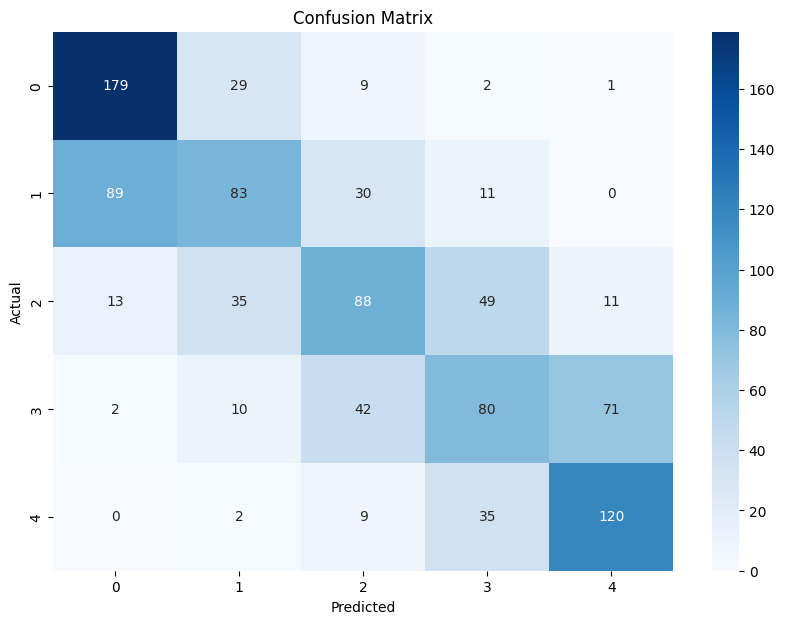

In [51]:
import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, predict_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()